<a href="https://colab.research.google.com/github/sajidcsecu/radioGenomic/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)

        return down, p


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
       x1 = self.up(x1)
       x = torch.cat([x1, x2], 1)
       return self.conv(x)

In [51]:
import torch
import torch.nn as nn

#from unet_parts import DoubleConv, DownSample, UpSample


class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)
        self.down_convolution_2 = DownSample(64, 128)
        self.down_convolution_3 = DownSample(128, 256)
        self.down_convolution_4 = DownSample(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up_convolution_1 = UpSample(1024, 512)
        self.up_convolution_2 = UpSample(512, 256)
        self.up_convolution_3 = UpSample(256, 128)
        self.up_convolution_4 = UpSample(128, 64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
       down_1, p1 = self.down_convolution_1(x)
       down_2, p2 = self.down_convolution_2(p1)
       down_3, p3 = self.down_convolution_3(p2)
       down_4, p4 = self.down_convolution_4(p3)

       b = self.bottle_neck(p4)

       up_1 = self.up_convolution_1(b, down_4)
       up_2 = self.up_convolution_2(up_1, down_3)
       up_3 = self.up_convolution_3(up_2, down_2)
       up_4 = self.up_convolution_4(up_3, down_1)

       out = self.out(up_4)
       return out

In [55]:
if __name__ == "__main__":
  double_conv = DoubleConv(256, 256)
  print(double_conv)
  input_image  = torch.randn((1, 1, 512, 512))
  model = UNet(1,2)
  out = model(input_image)
  print(out.shape)

DoubleConv(
  (conv_op): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
)
torch.Size([1, 2, 512, 512])


torch.Size([1, 1, 512, 512])


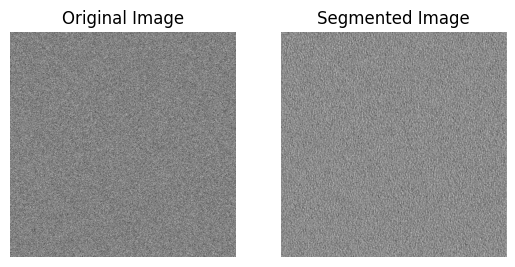

In [58]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
  image  = torch.randn((1, 1, 512, 512))
  model = UNet(1,1)
  out = model(image)
  print(out.shape)
  im = image.squeeze()
  im=im.detach().numpy()
  mi = out.squeeze()
  mi=mi.detach().numpy()
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(im, cmap="gray")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.title("Segmented Image")
  plt.imshow(mi, cmap="gray")
  plt.axis("off")
  plt.show()


In [8]:
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class CarvanaDataset(Dataset):
    def __init__(self, root_path, test=False):
        self.root_path = root_path
        if test:
            self.images = sorted([root_path+"/manual_test/"+i for i in os.listdir(root_path+"/manual_test/")])
            self.masks = sorted([root_path+"/manual_test_masks/"+i for i in os.listdir(root_path+"/manual_test_masks/")])
        else:
            self.images = sorted([root_path+"/train/"+i for i in os.listdir(root_path+"/train/")])
            self.masks = sorted([root_path+"/train_masks/"+i for i in os.listdir(root_path+"/train_masks/")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        mask = Image.open(self.masks[index]).convert("L")

        return self.transform(img), self.transform(mask)

    def __len__(self):
        return len(self.images)

In [10]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
  image = torch.randn((1, 1, 572, 572))
  model = UNet()
  # print(model)
  out = model(image)
  print(out.shape)
  im = image.squeeze()
  im=im.detach().numpy()
  mi = out.squeeze()
  mi=mi.detach().numpy()
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(im, cmap="gray")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.title("Segmented Image")
  plt.imshow(mi, cmap="gray")
  plt.axis("off")
  plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/uygar/unet-segmentation/data/train/'

# Implementing Original U-Net from scratch using PyTorch
https://l.facebook.com/l.php?u=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3Du1loyDCoGbE%26fbclid%3DIwZXh0bgNhZW0CMTAAAR2VkUy5YSkKgM217k9uLN1IsJ6PFc2ml2GGIuL6s-vxa-tOxsUqWf2GADw_aem_9e3yfWW-NMrFTmpOcNeaDA&h=AT3sTr1A0EUeDOQQNZJjimC4L3rTbMLLKZELl0Fi3J99GMKs7_awOzzgtqHteTu3ovy7q_GbyooiOWbq7sGn3LT0O9Wcnu3go1TE39noE-btWomXXn4iUlvbe5EJSjm5ZRD6Gg

In [48]:
import torch
import torch.nn as nn


class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.down_conv_1 = double_conv(1,64)
    self.down_conv_2 = double_conv(64,128)
    self.down_conv_3 = double_conv(128,256)
    self.down_conv_4 = double_conv(256,512)
    self.down_conv_5 = double_conv(512,1024)
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
    self.up_conv_1 = double_conv(1024,512)

    self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
    self.up_conv_2 = double_conv(512,256)
    self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.up_conv_3 = double_conv(256,128)
    self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.up_conv_4 = double_conv(128,64)

    self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)



  def forward(self, image):
    # encoder

    x1 = self.down_conv_1(image)
    # print(x1.size())
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)
    # print(x9.size())

    # decoder
    x= self.up_trans_1(x9)
    y= self.crop_img(x7,x)
    x = self.up_conv_1(torch.cat([x, y], 1))

    x= self.up_trans_2(x)
    y= self.crop_img(x5,x)
    x = self.up_conv_2(torch.cat([x, y], 1))

    x= self.up_trans_3(x)
    y= self.crop_img(x3,x)
    x = self.up_conv_3(torch.cat([x, y], 1))

    x= self.up_trans_4(x)
    y= self.crop_img(x1,x)
    x = self.up_conv_4(torch.cat([x, y], 1))
    x= self.out(x)
    return x

  def double_conv(self, in_c,out_c):
    conv = nn.Sequential(
      nn.Conv2d(in_c,out_c,kernel_size=3),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c,out_c,kernel_size=3),
      nn.ReLU(inplace=True),
    )
    return conv

  def crop_img(self, tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]


torch.Size([1, 1, 388, 388])


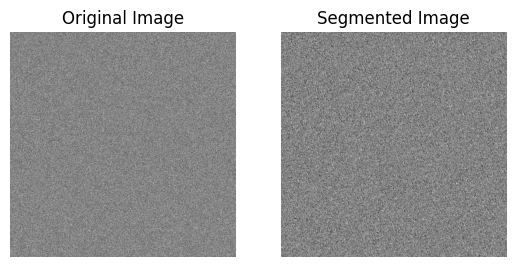

In [49]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
  image = torch.randn((1, 1, 572, 572))
  model = UNet()
  # print(model)
  out = model(image)
  print(out.shape)
  im = image.squeeze()
  im=im.detach().numpy()
  mi = out.squeeze()
  mi=mi.detach().numpy()
  plt.subplot(1, 2, 1)
  plt.title("Original Image")
  plt.imshow(im, cmap="gray")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.title("Segmented Image")
  plt.imshow(mi, cmap="gray")
  plt.axis("off")
  plt.show()

